In [2]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import xarray as xr
import pytensor.tensor as at
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


sys.path.append('../../')
from util.preprocessing_utils import standardize_column
from util.dataframe_utils import analyse_columns


In [3]:
df = pd.read_csv('../../data/processed/ProcessedTweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negative_reason,negative_reason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,fractional_hour,hour_sin,hour_cos
0,570306133677760513,0,1.0000,0,0.0000,0,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52-08:00,Unknown,Eastern Time (US & Canada),11.597778,0.105107,-0.994461
1,570301130888122368,1,0.3486,0,0.0000,0,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59-08:00,Unknown,Pacific Time (US & Canada),11.266389,0.190880,-0.981613
2,570301083672813571,0,0.6837,0,0.0000,0,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada),11.263333,0.191666,-0.981460
3,570301031407624196,2,1.0000,1,0.7033,0,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36-08:00,Unknown,Pacific Time (US & Canada),11.260000,0.192522,-0.981293
4,570300817074462722,2,1.0000,2,1.0000,0,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45-08:00,Unknown,Pacific Time (US & Canada),11.245833,0.196160,-0.980572


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df[['airline_sentiment_confidence', 'airline', 'hour_sin', 'hour_cos']], df['airline_sentiment'], test_size=0.2, random_state=42)

In [7]:
with pm.Model() as model:
    class_prior = pm.Dirichlet('class_prior', a=np.ones(len(np.unique(y_train))))

    means = pm.Normal('means', mu=0, sigma=10, shape=(len(np.unique(y_train)), X_train.shape[1]))
    sigmas = pm.HalfNormal('sds', sigma=10, shape=(len(np.unique(y_train)), X_train.shape[1]))

    feature_likelihoods = pm.Normal('feature_likelihoods', 
                                    mu=means[y_train], 
                                    sigma=sigmas[y_train], 
                                    observed=X_train)

    nuts_sampler_kwargs = {'target_accept': 0.99, 'max_treedepth': 20}
    trace = pm.sample(2000, tune=1000, nuts_sampler_kwargs=nuts_sampler_kwargs, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [class_prior, means, sds]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 73 seconds.


In [8]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"means[0, 0]",0.821,0.004,0.814,0.828,0.000,0.000,20921.0,5579.0,1.0
"means[0, 1]",2.601,0.030,2.543,2.655,0.000,0.000,20449.0,5479.0,1.0
"means[0, 2]",-0.036,0.014,-0.062,-0.010,0.000,0.000,20181.0,6110.0,1.0
"means[0, 3]",-0.383,0.012,-0.405,-0.360,0.000,0.000,19405.0,5388.0,1.0
"means[1, 0]",0.872,0.004,0.864,0.880,0.000,0.000,18486.0,5901.0,1.0
"means[1, 1]",2.528,0.033,2.465,2.592,0.000,0.000,19442.0,6075.0,1.0
"means[1, 2]",-0.060,0.017,-0.093,-0.029,0.000,0.000,19765.0,5147.0,1.0
"means[1, 3]",-0.356,0.013,-0.381,-0.330,0.000,0.000,19788.0,6053.0,1.0
"means[2, 0]",0.934,0.002,0.930,0.937,0.000,0.000,20393.0,5355.0,1.0
"means[2, 1]",2.929,0.019,2.893,2.963,0.000,0.000,18219.0,6045.0,1.0


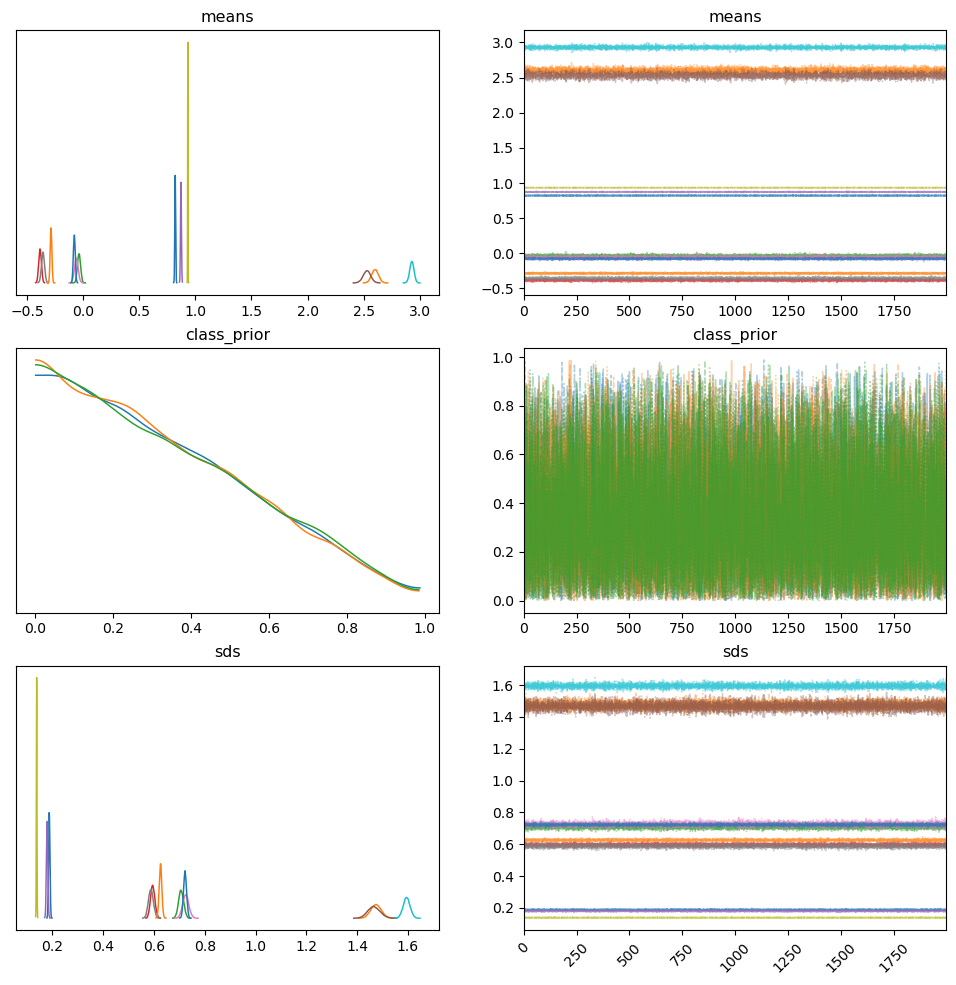

In [20]:
plt.rcParams['font.size'] = 10
az.plot_trace(trace, combined=True)
plt.xticks(rotation=45)
plt.subplots_adjust(top=2.5)
plt.subplots_adjust(bottom=1)